In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('ANSUR.csv')

In [8]:
df.shape

(3982, 166)

In [9]:
df.columns = df.columns.str.lower()

In [10]:
df.info(max_cols=170)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 166 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_number                    3982 non-null   int64  
 1   ab-ext-depth-sit                  3982 non-null   int64  
 2   acromion_ht                       3982 non-null   int64  
 3   acr_ht-sit                        3982 non-null   int64  
 4   acr-radl_lnth                     3982 non-null   int64  
 5   ankle_circ                        3982 non-null   int64  
 6   axilla_ht                         3982 non-null   int64  
 7   arm_circ-axillary                 3982 non-null   int64  
 8   foot_circ                         3982 non-null   int64  
 9   instep_lnth                       3982 non-null   int64  
 10  biacromial_brth                   3982 non-null   int64  
 11  armcircbcps_flex                  3982 non-null   int64  
 12  bidel

## Feature Selection

![image.png](attachment:1df52e2d-c997-4393-ac57-b41bac75c0dc.png)


### Seleção por correlação

Ao fazer uma análise exploratória podemos identificar visualmente duas ou mais
variáveis que são absolutamente correlacionadas. Muitas vezes pode ser uma
transformação de dados ou uma outra forma de derivada de capturar a mesma
informação. O fato é que ao variarem de uma maneira igual, elas registram exatamente
a mesma informação ao dataset. Para exemplificar, pegamos o dataset Ansur com
informações de homens e mulheres das forças armadas americanas. Vamos pegar um
subset do dataset com apenas 3 features originais (altura, peso em kg e gênero) e 2
features criadas a partir delas (peso em libras e o IMC). Vamos enxergar como essas
correlações ficam visivelmente claras:

In [11]:
df_sub = df[['stature','weight','gender']].copy()

In [12]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stature  3982 non-null   int64 
 1   weight   3982 non-null   int64 
 2   gender   3982 non-null   object
dtypes: int64(2), object(1)
memory usage: 93.5+ KB


In [13]:
df_sub['weight_lbs'] = df['estimated_weight,_lbs-ansur88']

In [14]:
df_sub['bmi'] = df['weight']*100000/df['stature']**2

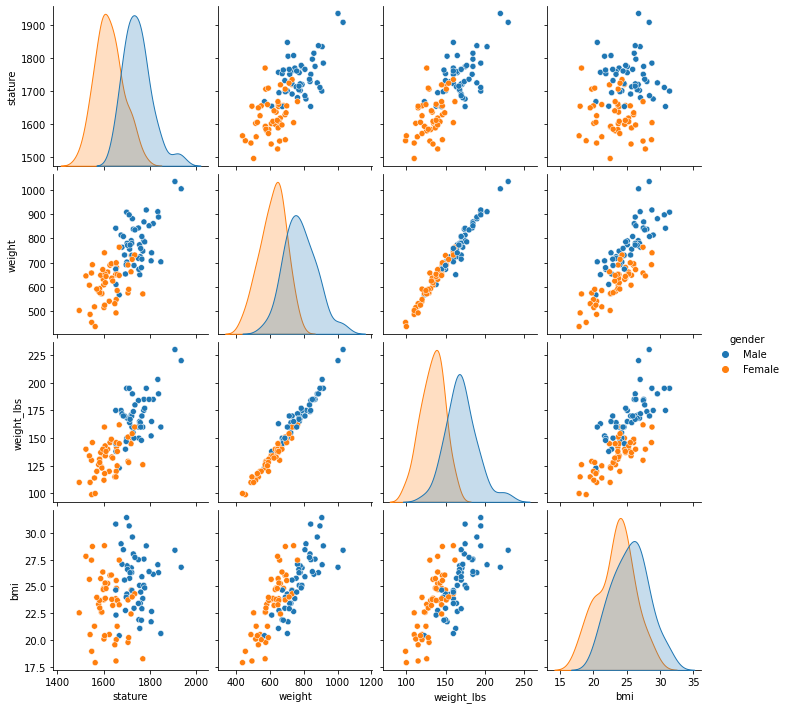

In [15]:
sns.pairplot(df_sub.sample(100),hue='gender')

Correlação perfeita entre peso em libras e peso em kg !

<AxesSubplot:>

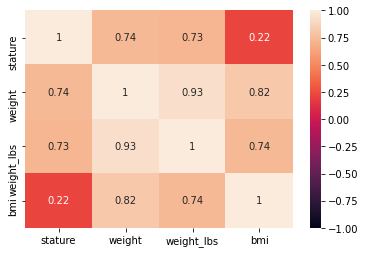

In [16]:
sns.heatmap(df_sub.corr(),vmax=1,vmin=-1,annot=True)

In [17]:
df_kg = df_sub.drop(columns=['weight_lbs'],axis= 1 ) # Drop columns with axis = 1 

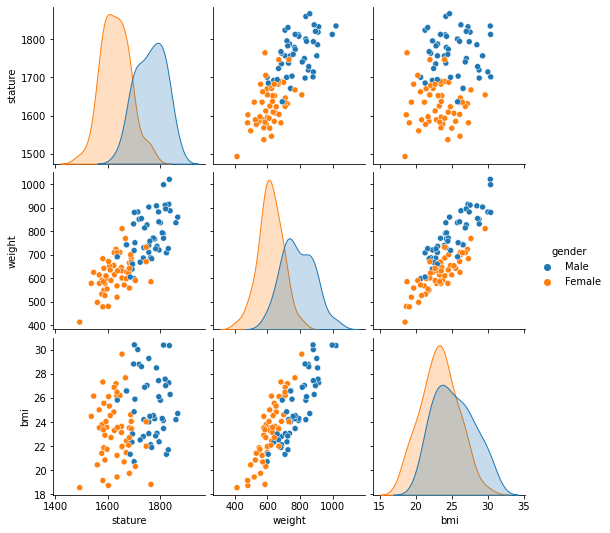

In [18]:
sns.pairplot(df_kg.sample(100),hue='gender')

Dependendo da análise que se vai fazer, é possível manter apenas o IMC e descartar as
duas features de peso e altura, já que estas últimas foram capturadas quase em sua
totalidade pelo IMC. Mas existem outras formas mais computacionais e estatísticas de
fazer uma feature selection.


## Seleção de features por variância
Como já vimos, a variância é um dos elementos que mais impacta na qualidade e
performance dos modelos. Logo, features com maiores variâncias vão impactar mais e
ser mais relevantes para o nosso modelo do que features com menos variância. Dessa
vez, vamos usar todas as features numéricas do dataset Ansur.

In [19]:
df.shape

(3982, 166)

In [20]:
df.columns

Index(['subject_number', 'ab-ext-depth-sit', 'acromion_ht', 'acr_ht-sit',
       'acr-radl_lnth', 'ankle_circ', 'axilla_ht', 'arm_circ-axillary',
       'foot_circ', 'instep_lnth',
       ...
       'race_of_mother-ansur88', 'race_of_father-ansur88', 'ethn_subject',
       'ethni_mother', 'ethni_father', 'birth_place', 'birth_pl_mother',
       'birth_pl_father', 'primary_mos_ansur88', 'secondary_mos_ansur88'],
      dtype='object', length=166)

Um ponto importante para que essa seleção por threshold tenha efeito é que todos os
dados estejam normalizados. Isso porque precisamos capturar apenas a variação
dentro de cada coluna as relações entre das diferentes escalas. Por exemplo, o tamanho
da mão é muito menor em centímetros que o tamanho da tíbia, mas ao normalizar,
preservamos apenas a variância dentro de cada coluna. Para normalizar as features,
basta dividirmos o valor da observação pela média da coluna em questão. Vamos aos
cálculos:


#### Separando catégoricas e númericas 

In [21]:
df_num = df.select_dtypes(include=[np.number])

In [22]:
df_num.shape

(3982, 165)

In [23]:
# importando VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

# Criando VarianceThreshold feature selector com 0.005
sel = VarianceThreshold(threshold=0.005)

# Fitando o selector ao df numeric normalizado
sel.fit(df_num / df_num.max()) # Não seria pelo max ? @!!!!!

# criando uma máscara de boleanos
# mask é um array contendo sel fitado e testa quem é maior que 0,005
mask = sel.get_support()

# Apply the mask to create a reduced dataframe! Novo dataframe
reduced_ansur = df_num.loc[:, mask]

In [24]:
reduced_ansur.shape

(3982, 51)

Wow! Com um threshold de apenas 0.005 de variância nosso dataset foi de 165 features para 51. É uma
redução e tanto. Esse método é uma espécie de força bruta e só deve ser usado quando se conhece muito
bem o dataset e os problemas de negócio que se está resolvendo. Mas podemos melhorar ainda mais a
forma de seleção.

## Seleção de features por performance do modelo
Uma das formas mais intuitivas de escolher as features em machine learning é através
do impacto delas no modelo que estamos usado. Para este exemplo vamos usar o
dataset Pima Indians editado. Nele temos 8 features com as pré-condições médicas de
392 pacientes e o objetivo é prever na coluna test se o paciente terá ou não diabetes.
Para que possamos prever de forma precisa, vamos usar o StandardScaler() que vai
padronizar os dados centrando a média de todas as features em 0 e a variância máxima
em 1.
Vamos fazer as importações necessárias e criar os datasets de treino e teste

In [25]:
db = pd.read_csv('diabetes.csv')

In [26]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [27]:
db.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
594,6,123,72,45,230,33.6,0.733,34,0
123,5,132,80,0,0,26.8,0.186,69,0
359,1,196,76,36,249,36.5,0.875,29,1
434,1,90,68,8,0,24.5,1.138,36,0
681,0,162,76,36,0,49.6,0.364,26,1


In [28]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [29]:
X=db.drop(columns=['Outcome'],axis= 1 )
y=db.Outcome

In [30]:
X.shape

(768, 8)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                     test_size=0.25,random_state=101)

In [32]:
# Instanciando o StandardScaler e a Regressão logística

scaler = StandardScaler()
lr = LogisticRegression()

# Vamos fittar e transformar os dados de uma só vez

X_train_std = scaler.fit_transform(X_train)
# Treinando a regressão linear no X_train padronizado
lr.fit(X_train_std, y_train)


# Precisamos transformar os dados de test também

X_test_std = scaler.transform(X_test)


# Fazendo predições com os dados padronizados

y_pred = lr.predict(X_test_std)


# imprimindo as métricas de acurácia e os coeficientes
# de importância das features

print("{0:.1%} accuracy on test set.".format(accuracy_score(y_test,
y_pred)))

print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))

78.1% accuracy on test set.
{'Pregnancies': 0.4, 'Glucose': 1.06, 'BloodPressure': 0.18, 'SkinThickness': 0.04, 'Insulin': 0.07, 'BMI': 0.68, 'DiabetesPedigreeFunction': 0.35, 'Age': 0.2}


Nossa, uma única feature tem um coeficiente muito maior que as demais.
Mas a simples presença de cada feature impacta no coeficiente das demais. Então não
seria prudente tirarmos todos de uma vez. Mas e se tirarmos os coeficientes mais
baixos e testar seu impacto?


In [33]:
#eliminamos duas features com menor coeficiente

X=X.drop(columns=['SkinThickness'],axis= 1 )
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [34]:
# Reamostrando os datasets de treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.25, random_state=0)

In [35]:
# vamos treinar e padronizar os dados em um step
lr.fit(scaler.fit_transform(X_train), y_train)

LogisticRegression()

In [36]:
# Verificando o impacto das features de menor coeficiente no modelo
acc = accuracy_score(y_test, lr.predict(scaler.transform(X_test)))
print("{0:.1%} accuracy on test set.".format(acc))
print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))


80.7% accuracy on test set.
{'Pregnancies': 0.3, 'Glucose': 1.02, 'BloodPressure': 0.19, 'Insulin': 0.08, 'BMI': 0.72, 'DiabetesPedigreeFunction': 0.3, 'Age': 0.25}


#### Testando apenas com a feature maior:

In [37]:
X = db[['Glucose']]

In [38]:
# Reamostrando os datasets de treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.25, random_state=0)

In [39]:
# Verificando o impacto das features de menor coeficiente no modelo

lr.fit(scaler.fit_transform(X_train), y_train)

acc = accuracy_score(y_test, lr.predict(scaler.transform(X_test)))
print("{0:.1%} accuracy on test set.".format(acc))
print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))


76.6% accuracy on test set.
{'Glucose': 1.16}


### Random Forest Feature Importance

O Random Forest possui naturalmente essa capacidade de gerar a importância
dos features que usa para fazer as suas previsões. Vamos novamente usar o Ansur
dataset. Vamos primeiro transformar as features numéricas em X e o target (Gênero)
em y e depois separar os datasets em treino e test:

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [41]:
X = df_num.drop(columns=['primary_mos_ansur88','secondary_mos_ansur88'],axis=1)
y = df['gender']

In [42]:
X.isnull().sum()

subject_number      0
ab-ext-depth-sit    0
acromion_ht         0
acr_ht-sit          0
acr-radl_lnth       0
                   ..
ethni_mother        0
ethni_father        0
birth_place         0
birth_pl_mother     0
birth_pl_father     0
Length: 163, dtype: int64

In [43]:
# Reamostrando os datasets de treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.25, random_state=0)

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(accuracy_score(y_test, rf.predict(X_test)))

0.9869477911646586


### Importância das Features:

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.feature_importances_)

[2.68032227e-03 1.03916219e-03 3.97337545e-04 3.82508348e-04
 7.05637582e-04 3.35947406e-04 8.76972663e-05 4.78037331e-04
 1.65016586e-02 5.68111814e-04 6.30073081e-03 3.42800465e-02
 2.94630440e-02 2.92268643e-02 1.27950938e-04 3.83310542e-04
 5.82209597e-04 2.10457014e-03 1.06385035e-03 1.35253276e-02
 3.73009842e-04 4.42216279e-04 1.48100939e-03 5.82499982e-03
 5.55808342e-04 3.29546538e-04 5.52395345e-04 4.87004608e-04
 9.16974960e-04 5.05851663e-04 9.67859406e-04 3.98532192e-04
 1.58300194e-02 1.59696887e-03 1.40863469e-02 5.42916144e-02
 4.88310554e-03 5.98373606e-03 4.19231739e-04 6.10969381e-04
 2.62884173e-03 1.79101753e-03 2.38618775e-04 2.58976284e-04
 2.96617088e-04 1.56281582e-03 4.08762737e-04 6.93862079e-02
 2.77280558e-04 4.10292964e-04 3.06230789e-02 3.68416855e-03
 6.15853233e-02 1.04796869e-02 9.26529649e-04 2.81327590e-04
 3.41476120e-04 4.19428712e-02 4.82175948e-02 2.27131994e-04
 6.95604447e-04 2.32485367e-04 5.68346272e-04 1.11137768e-02
 2.30103087e-04 5.399623

In [46]:
rf.feature_importances_.max()

0.0842827720780237

In [47]:
rf.feature_importances_.min()

0.0

In [48]:
#Poderíamos criar um seletor de features com máscara como já fizemos:


mask = rf.feature_importances_ > 0.1

X_reduced = X.loc[:, mask]

print(X_reduced.columns)

Index([], dtype='object')


In [49]:
X_reduced.shape

(3982, 0)

Mas isso seria bem arbitrário, porque sabemos que a cada vez que eliminamos uma
feature, ela impacta no coeficiente das demais. Uma outra solução ainda mais custosa
seria ir selecionando manualmente as variáveis com menor coeficiente e fazendo
rounds, digamos de 5 em 5. E se existisse uma forma de automatizar esse processo, em
que a cada round ele fosse eliminando uma quantidade de features com menor
coeficiente? Felizmente isso existe. É a Recursive Feature Elimination ou RFE. Vamos
vê-la em ação:

### Recursive Feature Elimination ou RFE

Neste caso como as features são afetadas seu grau de importância conforme rodamos o modelo, podemos simplesmente tirar de uma em uma.
Ou seja tira, analisa a menor e tira de novo
Um jeito de acelerar o processo é escolhendo o step = número de features a serem retiradas de uma vez.

In [50]:
# importando o pacote
from sklearn.feature_selection import RFE

In [51]:
# Instanciando o RFE
# Você passa o estimador dentro do RFE
# Também passa a quantidade de features a preservar
rfe = RFE(estimator=RandomForestClassifier(),
n_features_to_select=6, verbose=1) # Verbose ?
#Fitando nos dados
rfe.fit(X_train,y_train)

Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
F

RFE(estimator=RandomForestClassifier(), n_features_to_select=6, verbose=1)

In [52]:
print(accuracy_score(y_test, rfe.predict(X_test)))

0.9718875502008032


Step de 10

In [53]:
# Instanciando o RFE
# Você passa o estimador dentro do RFE
# Também passa a quantidade de features a preservar
rfe = RFE(estimator=RandomForestClassifier(),
n_features_to_select=6, step = 10, verbose=1) # Verbose ?
#Fitando nos dados
rfe.fit(X_train,y_train)
print(accuracy_score(y_test, rfe.predict(X_test)))

Fitting estimator with 163 features.
Fitting estimator with 153 features.
Fitting estimator with 143 features.
Fitting estimator with 133 features.
Fitting estimator with 123 features.
Fitting estimator with 113 features.
Fitting estimator with 103 features.
Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Fitting estimator with 23 features.
Fitting estimator with 13 features.
0.9698795180722891


A acurácia não é exatamente a mesma, mas pensando no ganho computacional, pode
ser um trade off interessante para datasets com alta dimensionalidade e um número de
observações gigantesca.

In [54]:
print(X.columns[rfe.support_])

Index(['forearm_circ-flexed', 'hand_circ_at_metacarpale',
       'neck_circ-over_larynx', 'neck_circ-base', 'scye_circ_over_acromion',
       'wrist_circ-stylion'],
      dtype='object')


## Feature extraction

Quando não conhecemos o negócio ou o dataset e ele possui um número muito grande
de features, é difícil muitas vezes, sequer saber por onde começar. As técnicas de
feature extraction, com algoritmos de aprendizado não supervisionados vão capturar
de forma automática a variância dos dados e extratir essa variância do espaço ndimensional para combinar em poucas features que perdem a sua interpretabilidade
inicial, mas que torna possível a sua representação em 2 ou 3 dimensões ou ainda,
reduz de forma considerável o processamento, permitindo a performance de modelos
black box.

![image.png](attachment:abc793ff-3e17-44fe-bacd-757e3e097437.png)


 - ### t-SNE:

t-SNE significa t-Distributed Stochastic Neighbor Embedding ou incorporação vizinha
estocástica distribuída em t, numa tradução livre. Apesar do nome, é uma técnica de
visualização de dados que permite que através de um processo de extração de dados,
transformemos um dataset n-dimensional em uma visualização de duas dimensões. O
t-SNE maximiza a distância entre os dados no espaço de alta dimensionalidade ou
high-dimensional e evidencia essa distância em duas dimensões. Mais uma vez, vamos
usar o dataset Ansur.
Vamos dropar todos os dados não numéricos e aplicar o t-SNE nas 94 features,
reduzindo-as à duas.

In [55]:
# Importando o t-SNE e o numpy
from sklearn.manifold import TSNE

In [56]:
# Contém apenas as colunas númericas de df

df_num_fixed = df_num.drop(columns=['primary_mos_ansur88',
                                    'secondary_mos_ansur88'],axis=1)

In [57]:
df_num_fixed.shape

(3982, 163)

In [58]:
# Instanciando o modelo t-SNE com learning rate 50
# geralmente o learning rate varia entre 10 e 1000

m = TSNE(learning_rate=50)

# Perceba que vamos fazer um fit e transformar os dados
# Dessa forma além de reduzir, transformaremos em duas np.array

tsne_features = m.fit_transform(df_num_fixed)

print(tsne_features.shape)

(3982, 2)


In [59]:
# Adicionando os dados ao dataset principal


df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

<AxesSubplot:xlabel='x', ylabel='y'>

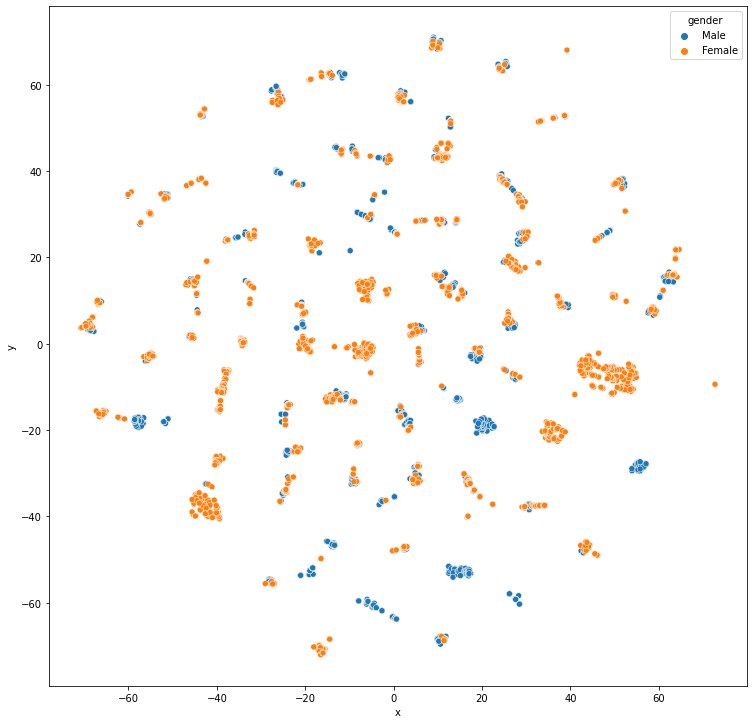

In [60]:
plt.figure(figsize=(12.5,12.5))
sns.scatterplot(x='x',y='y',hue='gender',data=df)

Sem essa redução de dimensionalidade seria muito difícil chegarmos à uma forma
simples de interpretar mais de 90 dimensões

## PCA

Principal Component Analysis ou análise da componente principal é uma das
principais técnicas de feature extraction. Além da visualização para EDA, ela pode ser
usada como uma forma de transformação dos dados, similar à normalização ou à
padronização, só que bem mais poderosa. A PCA plota todos os dados em espaço ndimensional e rotaciona os dados até que esses dados possam ser expressos na maior
variância possível em novas dimensões. Estas novas dimensões concentram e
preservam as variâncias, mas não possuem mais a mesma interpretabilidade, já que
não estamos falando mais de features, e sim, de Componentes Principais. Entenda um
pouco melhor a diferença entre o comportamento das features de dos Componentes
Principais:

In [61]:
df.info(max_cols=170)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 168 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_number                    3982 non-null   int64  
 1   ab-ext-depth-sit                  3982 non-null   int64  
 2   acromion_ht                       3982 non-null   int64  
 3   acr_ht-sit                        3982 non-null   int64  
 4   acr-radl_lnth                     3982 non-null   int64  
 5   ankle_circ                        3982 non-null   int64  
 6   axilla_ht                         3982 non-null   int64  
 7   arm_circ-axillary                 3982 non-null   int64  
 8   foot_circ                         3982 non-null   int64  
 9   instep_lnth                       3982 non-null   int64  
 10  biacromial_brth                   3982 non-null   int64  
 11  armcircbcps_flex                  3982 non-null   int64  
 12  bidel

In [62]:
red_features = ['stature','buttock_circ','waist_circ_natural','shoulder_circ']

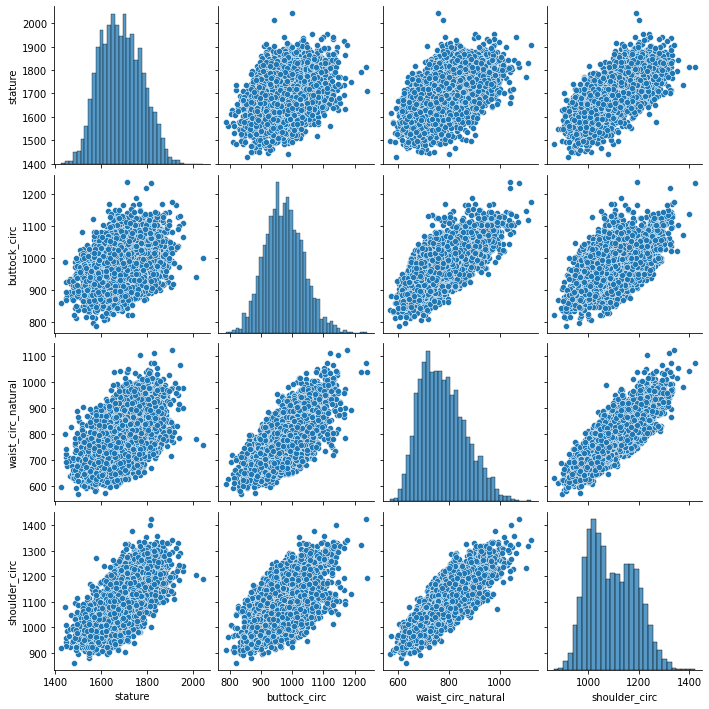

In [63]:
sns.pairplot(df[red_features])

In [64]:
# Importando os pacotes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [65]:
# É imprescindível padronizar os dados antes do PCA
scaler = StandardScaler()
ansur_std = scaler.fit_transform(df[red_features])


# Instanciando, fittando e transformando com PCA
pca = PCA()
pc = pca.fit_transform(df_num[red_features])


# Criando um df a partir dos resultados da transformação
pc_df = pd.DataFrame(pc, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4'])

LinAlgError: SVD did not converge

In [ ]:
# criando um pairplot a partir do novo DataFrame
sns.pairplot(pc_df)
plt.show()


### Explicação da variância
Talvez essa seja uma das propriedades únicas que torna o PCA tão especial. Uma vez
que você passa o PCA nos seus dados, é possível acessar a variância de cada
componente principal:

In [ ]:
print(pca.explained_variance_ratio_)

Talvez melhor ainda que isso, é possível acessar a soma acumulada do percentual de
variância a cada nova feature:

In [ ]:
print(pca.explained_variance_ratio_.cumsum())

In [ ]:
sns.barplot(x=pca.explained_variance_ratio_,y=pca.explained_variance_ratio_.cumsum())
plt.xticks(rotation=90);


Dessa forma, podemos saber de antemão, de que percentual de informação dos dados
estamos abrindo mão ao escolher um recorte que limita a dimensionalidade

#### PCA como redução de dimensionalidade no Pipeline
Um dos super poderes do PCA é poder transformar os dados direto no pipeline. Sem a
necessidade de um step fora do pipeline, essa poderosa ferramenta se torna ainda mais
prática e uma das melhores amigas de data scientists para combater as altas
dimensionalidades e datasets com muito ruído. Vamos à sua implementação:

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
X = df_num.drop(columns=['primary_mos_ansur88','secondary_mos_ansur88'],axis=1)
y = df['gender']

In [ ]:
# Construindo o pipeline
pipe = Pipeline([
('scaler', StandardScaler()),
('reducer', PCA(n_components=3)),
('classifier', RandomForestClassifier(random_state=0))])


# Fittando o pipeline nos dados
pipe.fit(X_train, y_train)


# mensurando a acurácia e armazenando em uma variável
accuracy = pipe.score(X_test, y_test)

# Imprimindo o percentual acumulado de variânciados dados em 3 PCAs
# Após o .fit é possivel acessar os elementos do pipiline com []
print(pipe.steps[1][1].explained_variance_ratio_.cumsum())

In [ ]:
print('{0:.1%} test set accuracy'.format(accuracy))

Wow!! Tudo isso para apenas 3 Componentes Principais? É um custo benefício absurdo!

# Conclusão

Que bom que você chegou até aqui! Redução de dimensionalidade é uma ferramenta
poderosa que pode te ajudar desde o entendimento dos dados na fase de exploração
dos dados, até formas de selecionar features, quando se deseja manter a
interpretabilidade e até mesmo, melhorar a acurácia do seu modelo através da
extração de features.
Espero que tenha conseguido acompanhar todas as explicações. Lembre-se, este
material não é um guia completo, mas um ponto de partida para que você tenha uma
intuição inicial e uma série de skills que vão te dar a confiança e o background
necessários para buscar mais informações e explicações complementares.
Não esqueça, a comunidade de data science faz toda a diferença. Poste suas dúvidas e
aprendizados no Slack da sua turma. Ajude aos colegas com mais dificuldade ou peça
ajuda. Tem sempre alguém do Time Tera pronto para te ajudar